In [1]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from matplotlib.colors import BoundaryNorm, ListedColormap
from notebook_init_utils import bandicoot_check, init_notebook
from skimage import io
from technical_analysis_segmentation_utils import (
    convert_indexed_mask_to_binary_mask,
    extract_IOU,
    signed_xor_3color,
)

root_dir, in_notebook = init_notebook()

if in_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
image_base_dir

PosixPath('/home/lippincm/mnt/bandicoot/NF1_organoid_data')

In [3]:
well_fovs = ["F4-1", "F4-2", "F4-3"]

NF0037_T1Z1_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-1/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_5_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.5/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_2_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.2/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_1_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.1/segmentation_masks/"
).resolve(strict=True)

In [4]:
compartment = "Organoid"
well_fov = "F4-1"
NF0037_T1Z1_files = list(pathlib.Path(f"{NF0037_T1Z1_path}/{well_fov}").glob("*.tif*"))
NF0037_T1Z0_5_files = list(
    pathlib.Path(f"{NF0037_T1Z0_5_path}/{well_fov}").glob("*.tif*")
)
NF0037_T1Z0_2_files = list(
    pathlib.Path(f"{NF0037_T1Z0_2_path}/{well_fov}").glob("*.tif*")
)
NF0037_T1Z0_1_files = list(
    pathlib.Path(f"{NF0037_T1Z0_1_path}/{well_fov}").glob("*.tif*")
)

mask_of_interest_T1Z1 = [
    i for i in NF0037_T1Z1_files if compartment.lower() in i.name.lower()
][0]
mask_of_interest_T1Z0_5 = [
    i for i in NF0037_T1Z0_5_files if compartment.lower() in i.name.lower()
][0]
mask_of_interest_T1Z0_2 = [
    i for i in NF0037_T1Z0_2_files if compartment.lower() in i.name.lower()
][0]
mask_of_interest_T1Z0_1 = [
    i for i in NF0037_T1Z0_1_files if compartment.lower() in i.name.lower()
][0]
mask_T1Z1 = read_zstack_image(mask_of_interest_T1Z1)
mask_T1Z0_5 = read_zstack_image(mask_of_interest_T1Z0_5)
mask_T1Z0_2 = read_zstack_image(mask_of_interest_T1Z0_2)
mask_T1Z0_1 = read_zstack_image(mask_of_interest_T1Z0_1)

In [5]:
print(f"Mask shapes: T1Z1: {mask_T1Z1.shape}")
print(f"Mask shapes: T1Z0.5: {mask_T1Z0_5.shape}")
print(f"Mask shapes: T1Z0.2: {mask_T1Z0_2.shape}")
print(f"Mask shapes: T1Z0.1: {mask_T1Z0_1.shape}")

Mask shapes: T1Z1: (63, 1507, 1508)
Mask shapes: T1Z0.5: (107, 1526, 1528)
Mask shapes: T1Z0.2: (265, 1526, 1528)
Mask shapes: T1Z0.1: (527, 1526, 1528)


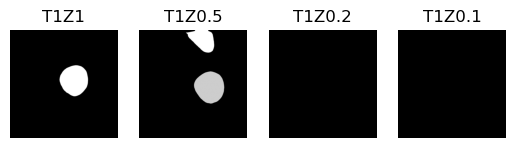

In [24]:
plt.subplot(141)
plt.imshow(mask_T1Z1[35, :, :], cmap="gray")
plt.title("T1Z1")
plt.axis("off")
plt.subplot(142)
plt.imshow(mask_T1Z0_5[60, :, :], cmap="gray")
plt.title("T1Z0.5")
plt.axis("off")
plt.subplot(143)
plt.imshow(mask_T1Z0_2[130, :, :], cmap="gray")
plt.title("T1Z0.2")
plt.axis("off")
plt.subplot(144)
plt.imshow(mask_T1Z0_1[280, :, :], cmap="gray")
plt.title("T1Z0.1")
plt.axis("off")
plt.show()

In [31]:
empty_slices_T1Z1 = 0
for slice_ in range(mask_T1Z0_1.shape[0]):
    if len(np.unique(mask_T1Z0_1[slice_, :, :])) == 1:
        empty_slices_T1Z1 += 1
print(f"Number of empty slices in T1Z0_1: {empty_slices_T1Z1}")

Number of empty slices in T1Z0_1: 527
